In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

In [2]:
import utils as U
import opt_runs as OR
import opt_model as OM
import decorated_options as Deco

/Users/musically_ut/prog/work/LVIV-2018/redqueen/opt_runs.py:19: UserWarning: broadcast.opt.optimizer was NOT imported. Comparison against method of Karimi et. al. method will not be possible.
  warnings.warn('broadcast.opt.optimizer was NOT imported. '


# Step 1: Create a SimOpts which will generate raw data

In [3]:
sim_opts_1_follower = OM.SimOpts(
    src_id=0,
    end_time=100,
    s=np.array([1]),
    q=1.0,
    other_sources=[('Hawkes', {'src_id': 1, 'seed': 1, 'l_0': 1.0, 'alpha': 1.0, 'beta': 5.0})],
    sink_ids=[1000],
    edge_list=[(0, 1000), (1, 1000)]
)
src_id = sim_opts_1_follower.src_id

# Step 2: Simulate the walls along with different strategies for our broadcaster

### RedQueen

In [4]:
%%time
seed = 1
opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
opt_mgr.run_dynamic()
opt_df = opt_mgr.state.get_dataframe()
num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=src_id)
perf_opt = {
    'type': 'Opt',
    'seed': seed,
    'capacity': num_opt_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_opt, opt_df, sim_opts_1_follower)

CPU times: user 83.7 ms, sys: 4.23 ms, total: 88 ms
Wall time: 90.1 ms


In [5]:
perf_opt

{'avg_rank': 66.8116376874034,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 138.15727122691501,
 'seed': 1,
 'top_1': 56.517519051405124,
 'type': 'Opt',
 'world_events': 154}

### Poisson

In [6]:
%%time
seed = 9
poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=num_opt_tweets)
poisson_mgr.run_dynamic()
poisson_df = poisson_mgr.state.get_dataframe()
num_poisson_tweets = U.num_tweets_of(poisson_df, broadcaster_id=src_id)
perf_poisson = {
    'type': 'Poisson',
    'seed': seed,
    'capacity': num_poisson_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_poisson, poisson_df, sim_opts_1_follower)

CPU times: user 88.3 ms, sys: 3.04 ms, total: 91.3 ms
Wall time: 93.6 ms


In [7]:
perf_poisson

{'avg_rank': 201.3461740580856,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 1341.2792390212567,
 'seed': 9,
 'top_1': 39.68728199394901,
 'type': 'Poisson',
 'world_events': 154}

### Piecewise constant

In [8]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

# Keep the rate such that the number of events is roughtly the same as the number of posts
# made by RedQueen, but such that intensity of posting increases with time.
segments = 10
change_times = np.arange(0, segments) * T / segments
rates = np.arange(0, segments) * (2 * num_opt_tweets / T) / (segments - 1)

pwc_mgr = sim_opts_1_follower.create_manager_with_piecewise_const(
    seed, 
    change_times=change_times,
    rates=rates
)

pwc_mgr.run_dynamic()
pwc_df = pwc_mgr.state.get_dataframe()
num_pwc_tweets = U.num_tweets_of(pwc_df, broadcaster_id=src_id)
perf_pwc = {
    'type': 'PWC',
    'seed': seed,
    'capacity': num_pwc_tweets,
}
OR.add_perf(perf_pwc, pwc_df, sim_opts_1_follower)

CPU times: user 76.8 ms, sys: 1.06 ms, total: 77.8 ms
Wall time: 78.8 ms


In [9]:
perf_pwc

{'avg_rank': 792.0379281739264,
 'capacity': 78.0,
 'num_events': 78,
 'r_2': 22260.201256104978,
 'seed': 24,
 'top_1': 31.66329884023582,
 'type': 'PWC',
 'world_events': 154}

### Smart Poisson

In [27]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

rate = num_opt_tweets / T * 4
sp_mgr = sim_opts_1_follower.create_manager_with_smart_poisson(
    seed,
    rate=rate
)

sp_mgr.run_dynamic()
sp_df = sp_mgr.state.get_dataframe()
num_sp_tweets = U.num_tweets_of(sp_df, broadcaster_id=src_id)
perf_sp = {
    'type': 'Smart Poisson',
    'seed': seed,
    'capacity': num_sp_tweets,
}
OR.add_perf(perf_sp, sp_df, sim_opts_1_follower)

CPU times: user 101 ms, sys: 3.45 ms, total: 104 ms
Wall time: 120 ms


In [28]:
perf_sp

{'avg_rank': 77.16101427531228,
 'capacity': 80.0,
 'num_events': 80,
 'r_2': 403.80126498258875,
 'seed': 24,
 'top_1': 63.975107578107554,
 'type': 'Smart Poisson',
 'world_events': 154}

# Step 3: Study the performance

In [11]:
print('num_opt_tweets = {}, num_poisson_tweets = {}'
      .format(U.num_tweets_of(opt_df, 0), U.num_tweets_of(poisson_df, 0)))

num_opt_tweets = 78.0, num_poisson_tweets = 78.0


In [12]:
print('avg_rank_opt = {}, avg_rank_poisson = {}'
      .format(U.average_rank(opt_df, sim_opts=sim_opts_1_follower), 
              U.average_rank(poisson_df, sim_opts=sim_opts_1_follower)))

avg_rank_opt = 66.8116376874034, avg_rank_poisson = 201.3461740580856


In [13]:
K = 1
print('Time spent in the top-{} by Redqueen = {} and Poisson = {}'
      .format(K, 
              U.time_in_top_k(opt_df, K=K, sim_opts=sim_opts_1_follower),
              U.time_in_top_k(poisson_df, K=K, sim_opts=sim_opts_1_follower)))

Time spent in the top-1 by Redqueen = 56.517519051405124 and Poisson = 39.68728199394901


### Plot evolution

In [14]:
def plot_rank_evolution(df, src_id):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    ranks = U.rank_of_src_in_df(df, src_id).mean(axis=1)
    
    fig, ax1 = plt.subplots()
    
    ax1.fill_between(ranks.index, ranks.values, step='post',
                     color=c1, label=r'$\bar{r}(t)$', alpha=0.5)
    
    ax1.set_ylabel('Rank')
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    ax1.set_ylim(0)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    plt.tight_layout()

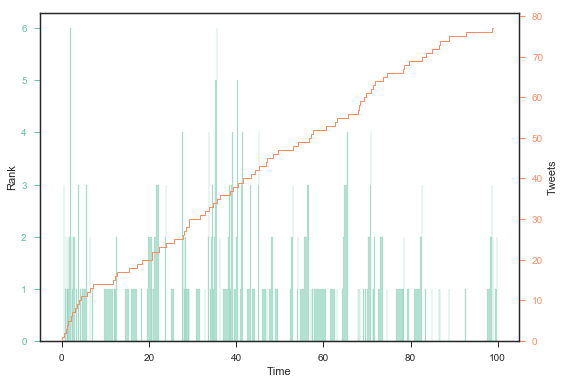

In [15]:
plot_rank_evolution(opt_df, src_id)

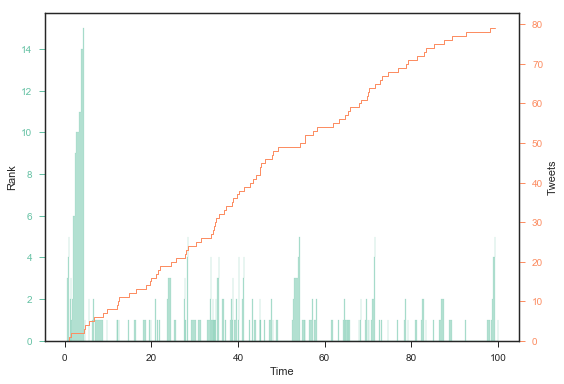

In [30]:
plot_rank_evolution(sp_df, src_id)

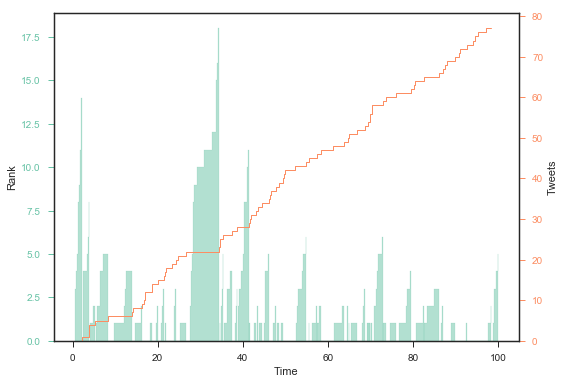

In [16]:
plot_rank_evolution(poisson_df, src_id)

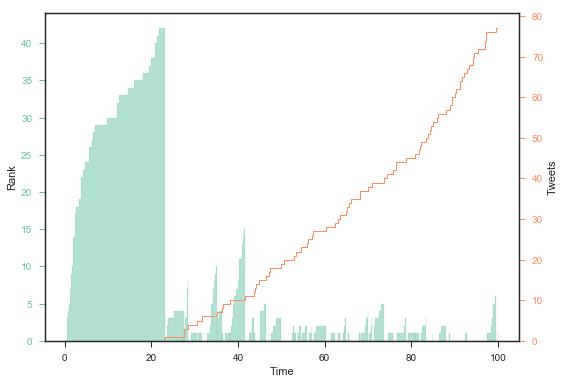

In [17]:
plot_rank_evolution(pwc_df, src_id)

In [43]:
def plot_top_k_evolution(df, src_id, K=1, T=100, ymax=None):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    top_k = (U.rank_of_src_in_df(df, src_id) < K).mean(axis=1)
    
    times = np.asarray([0] + top_k.index.values.tolist() + [T])
    t_diff = np.diff(times)
    top_k_indicator = np.array([0] + top_k.values.tolist())

    fig, ax1 = plt.subplots()    

    ax1.fill_between(times[:-1], np.cumsum(top_k_indicator * t_diff), step='post',
                     color=c1, label=r'$1_{[r(t) <= %d]}$' % K,
                     alpha=0.5)
    
    ax1.set_ylabel('Time in Top-{}'.format(K))
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    
    if ymax is None:
        ax1.set_ylim(0)
    else:
        ax1.set_ylim(0, ymax)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    # plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    plt.tight_layout()

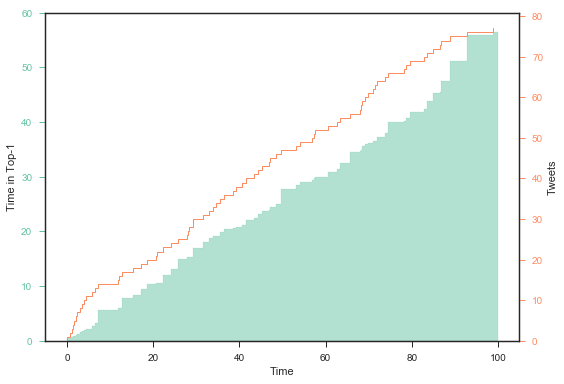

In [45]:
plot_top_k_evolution(opt_df, src_id, ymax=60)

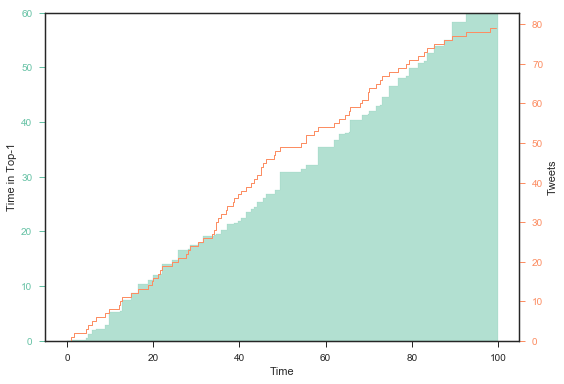

In [46]:
plot_top_k_evolution(sp_df, src_id, ymax=60)

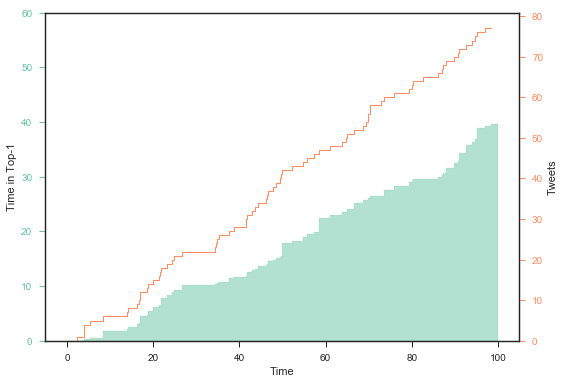

In [47]:
plot_top_k_evolution(poisson_df, src_id, ymax=60)

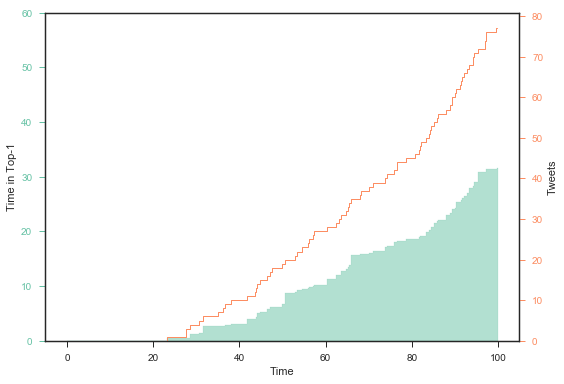

In [48]:
plot_top_k_evolution(pwc_df, src_id, ymax=60)